In [29]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, Normalize

In [2]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)

System Version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
PyTorch version 2.1.2+cpu
Torchvision version 0.16.2+cpu


# Pytorch Dataset


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

In [5]:
# Define your loss function
criterion = nn.CrossEntropyLoss()

In [6]:
dataset = BrainTumorDataset(
    data_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection'
)

In [7]:
len(dataset)

506

1


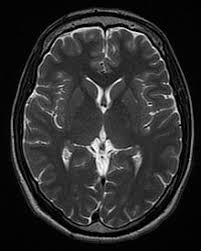

In [8]:
image, label = dataset[300]
print(label)
image

In [22]:
# iterate over dataset
for image, label in dataset:
    break

In [21]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

# Create data loaders

In [20]:
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
dataset = BrainTumorDataset(data_dir, transform)

In [24]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
# Define constants
batch_size = 32
random_seed = 42

In [12]:
train_folder = '../input/brain-mri-images-for-brain-tumor-detection'
valid_folder = '../input/brain-mri-images-for-brain-tumor-detection/'
test_folder = '../input/brain-mri-images-for-brain-tumor-detection/'

In [13]:
train_dataset = BrainTumorDataset(train_folder, transform=transform)
val_dataset = BrainTumorDataset(valid_folder, transform=transform)
test_dataset = BrainTumorDataset(test_folder, transform=transform)

In [14]:
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
for images, labels in dataloader:
    break

In [26]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [27]:
labels

tensor([0, 2, 1, 1, 2, 2, 0, 1, 1, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 1, 2, 2, 0, 2, 2])

# Define the Model

In [16]:
class BrainTumorClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(BrainTumorClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [17]:
# Create an instance of the model
model = BrainTumorClassifer(num_classes=53)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [28]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

# Training loop

In [31]:
# Simple training loop
num_epochs = 5

train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BrainTumorClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

In [33]:
# Validation phase
model.eval()
running_loss = 0.0
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Validation loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
         
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Validation loop:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.8457015651488021, Validation loss: 0.7928646294024622


# Visualize Losses

In [34]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

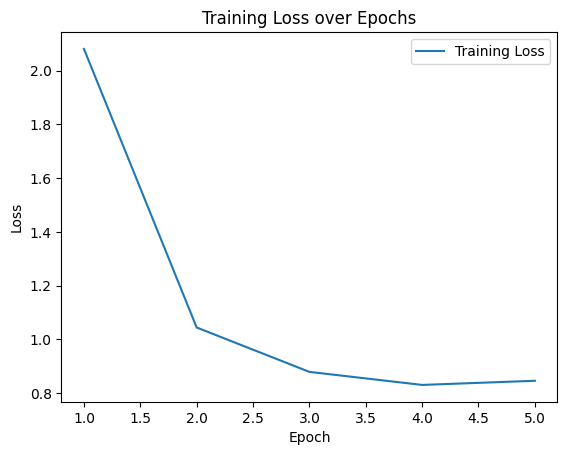

In [40]:
# Plotting the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [41]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

In [42]:
# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

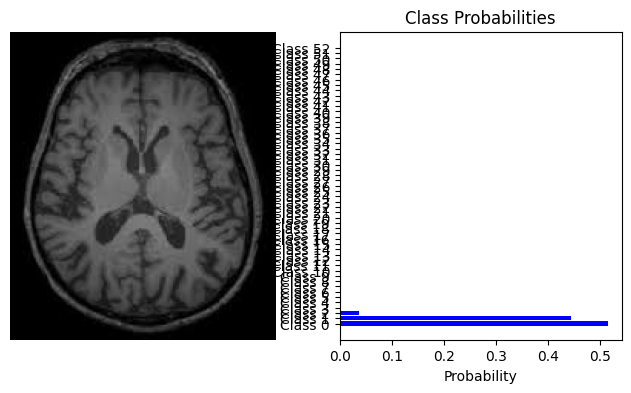

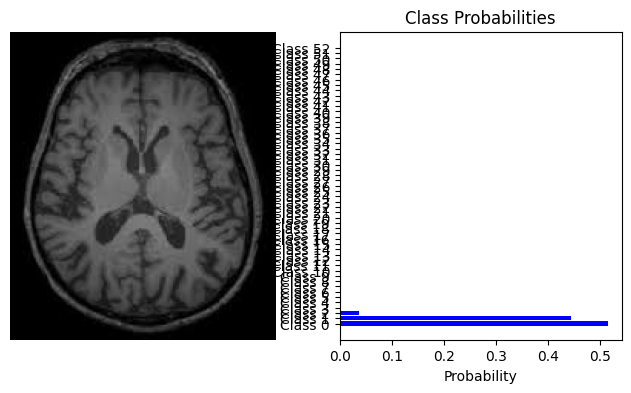

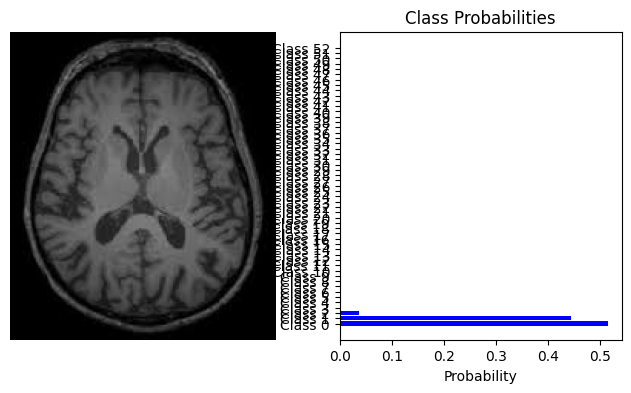

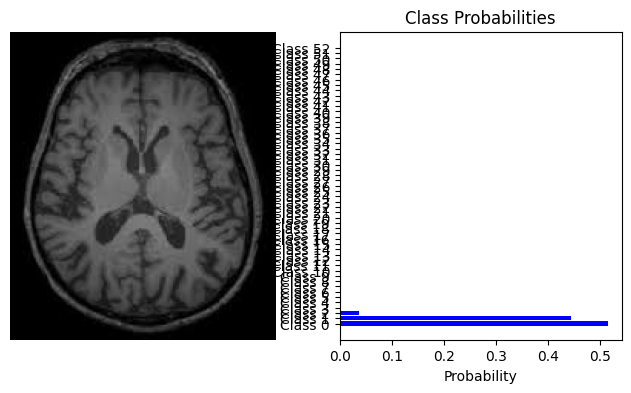

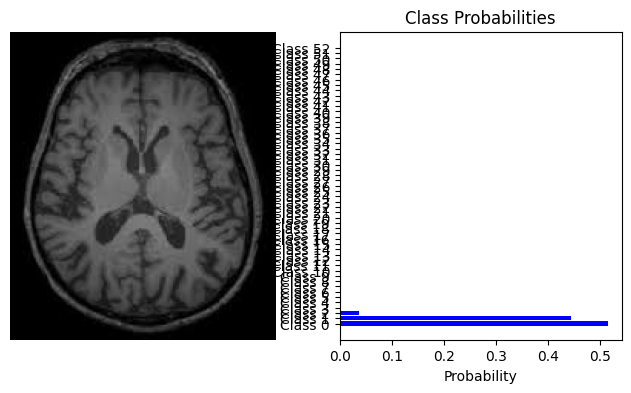

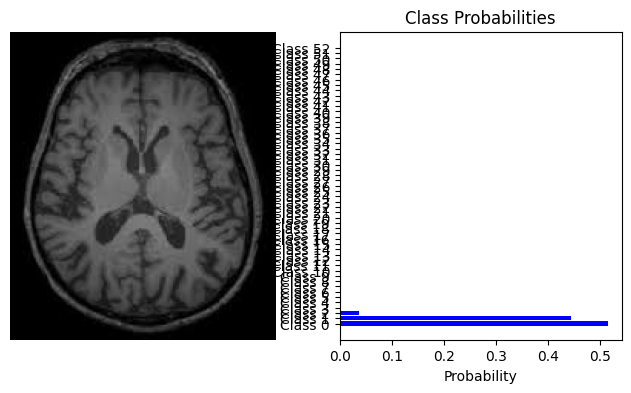

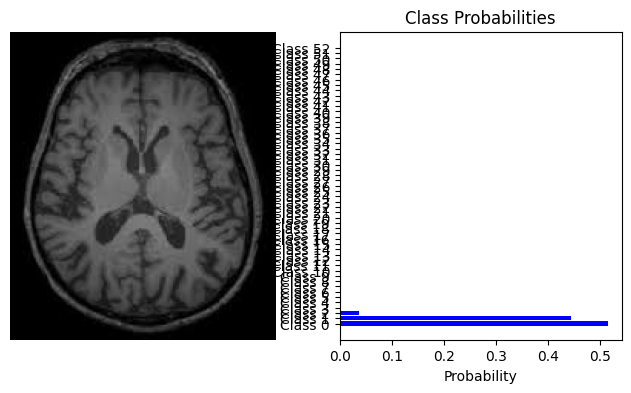

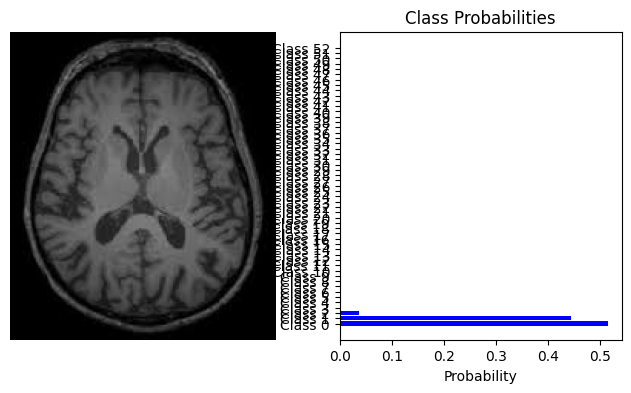

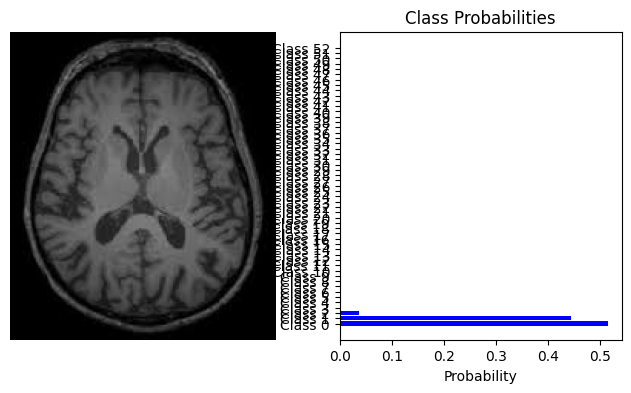

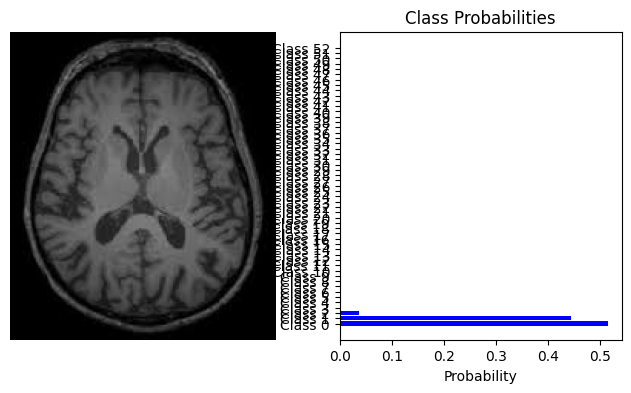

In [57]:
# Visualization
# Function to visualize predictions
def visualize_predictions(original_image, probabilities):
    num_classes = len(probabilities)
    class_names = [f'Class {i}' for i in range(num_classes)]  # Dynamic class names
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(range(num_classes), probabilities, color='blue')
    plt.yticks(range(num_classes), class_names)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.show()

# Path to test images
test_images = glob('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)
    visualize_predictions(original_image, probabilities)

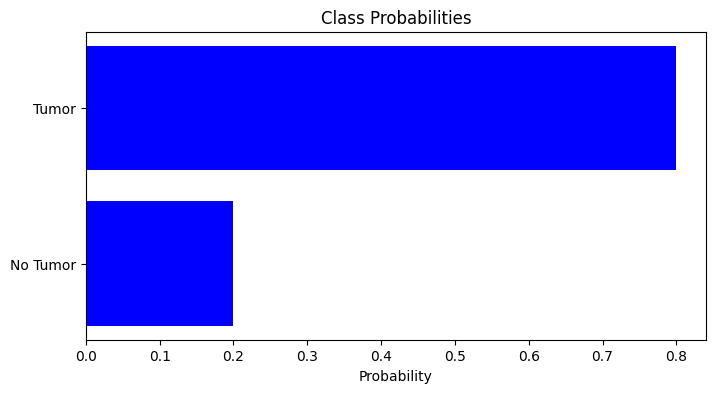

In [58]:
def visualize_predictions_bar_chart(probabilities, class_names):
    num_classes = len(class_names)
    plt.figure(figsize=(8, 4))
    
    # Create horizontal bar chart
    y_pos = np.arange(num_classes)
    plt.barh(y_pos, probabilities, align='center', color='blue')
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')

    plt.show()

# Example usage:
probabilities = [0.2, 0.8]  # Example probabilities for two classes
class_names = ['No Tumor', 'Tumor']  # Example class names

visualize_predictions_bar_chart(probabilities, class_names)

# THE END